# Build Crime Model

### **classification model** to predict serious and non-serious crime types based on features like location, time, and victim demographics.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score

from joblib import dump, load

# Ensure all columns are displayed
pd.set_option('display.max_columns', None)

# Load Data

In [2]:
dir_path = '../data/' # Change to your directory path
file_name = 'cleaned_data.csv' # Change to your file name

In [3]:
# dir_path = '/path/to/data/directory/' # Change to your directory path
# file_name = 'cleaned_data.csv' # Change to your file name

In [4]:
# read CSV in chunks
def read_in_chunks(file_path, chunk_size=100_000): # Set chunk size
    df_list = []
    chunks = pd.read_csv(file_path, 
                         chunksize=chunk_size, 
                         dtype={'TIME OCC':str,  # Format 24-hour time as '%H%M' str
                               'Premis Cd':str}) # Format Premis Cd values as str
    for chunk in chunks:
        df_list.append(chunk)  # Store chunks in list
    return pd.concat(df_list, ignore_index=True)  # Combine chunks into full DataFrame

In [5]:
# read a random sample
def read_random_sample(file_path, sample_fraction=0.1): # Set sample size
    full_df = read_in_chunks(file_path)  # Read full data in chunks
    sampled_df = full_df.sample(frac=sample_fraction, random_state=42)  # Take random sample but make random sampling return same results every time
    return sampled_df  

In [6]:
# path to full data
file_path = dir_path +  file_name

In [7]:
# Read full data in chunks
full_df = read_in_chunks(file_path)

In [8]:
full_df.shape

(1005104, 22)

In [9]:
# Read random sample
df = read_random_sample(file_path)

In [10]:
df.shape

(100510, 22)

In [11]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Status,Status Desc,Crm Cd 1,LOCATION,LAT,LON
624116,221410372,2022-05-06,2022-05-03,04:05:00,14,Pacific,1414,1,522,"VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...",0344,32,M,H,102.0,SIDEWALK,IC,Invest Cont,522.0,7TH,33.9996,-118.4690
983199,241410620,2024-06-19,2024-06-19,00:49:00,14,Pacific,1494,1,440,THEFT PLAIN - PETTY ($950 & UNDER),1822 0344,33,F,B,212.0,TRANSPORTATION FACILITY (AIRPORT),IC,Invest Cont,440.0,200 WORLD WY,33.9455,-118.4003
430681,222107656,2022-04-04,2022-04-03,01:04:00,21,Topanga,2132,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,0385,45,F,W,501.0,SINGLE FAMILY DWELLING,IC,Invest Cont,331.0,7100 FOREST HILLS RD,34.1980,-118.6402
631116,220322533,2022-12-30,2022-12-26,13:30:00,3,Southwest,361,1,510,VEHICLE - STOLEN,X,0,X,X,101.0,STREET,IC,Invest Cont,510.0,4800 TACANA ST,34.0163,-118.3515
14072,200606894,2020-02-24,2020-02-24,03:55:00,6,Hollywood,637,2,623,BATTERY POLICE (SIMPLE),0447 1212 2004 1822,25,F,H,203.0,OTHER BUSINESS,IC,Invest Cont,623.0,5900 HOLLYWOOD BL,34.1030,-118.3225


# Prepare Data

In [12]:
# Convert DATE OCC to datetime and extract features
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], errors="coerce")

In [13]:
# Convert TIME OCC to numeric
# df["TIME OCC"] = pd.to_numeric(df["TIME OCC"], errors="coerce")
df["TIME OCC"] = pd.to_datetime(df["TIME OCC"], format="%H:%M:%S", errors="coerce")

In [14]:
# Extract hour from 4-digit time format (e.g., 1530 → 15)
# df["Hour"] = df["TIME OCC"] // 100
df["Hour"] = df["TIME OCC"].dt.hour

In [15]:
df["Day"] = df["DATE OCC"].dt.dayofweek  # Monday = 0, Sunday = 6

In [16]:
df["Month"] = df["DATE OCC"].dt.month

In [17]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Status,Status Desc,Crm Cd 1,LOCATION,LAT,LON,Hour,Day,Month
624116,221410372,2022-05-06,2022-05-03,1900-01-01 04:05:00,14,Pacific,1414,1,522,"VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...",0344,32,M,H,102.0,SIDEWALK,IC,Invest Cont,522.0,7TH,33.9996,-118.4690,4,1,5
983199,241410620,2024-06-19,2024-06-19,1900-01-01 00:49:00,14,Pacific,1494,1,440,THEFT PLAIN - PETTY ($950 & UNDER),1822 0344,33,F,B,212.0,TRANSPORTATION FACILITY (AIRPORT),IC,Invest Cont,440.0,200 WORLD WY,33.9455,-118.4003,0,2,6
430681,222107656,2022-04-04,2022-04-03,1900-01-01 01:04:00,21,Topanga,2132,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,0385,45,F,W,501.0,SINGLE FAMILY DWELLING,IC,Invest Cont,331.0,7100 FOREST HILLS RD,34.1980,-118.6402,1,6,4
631116,220322533,2022-12-30,2022-12-26,1900-01-01 13:30:00,3,Southwest,361,1,510,VEHICLE - STOLEN,X,0,X,X,101.0,STREET,IC,Invest Cont,510.0,4800 TACANA ST,34.0163,-118.3515,13,0,12
14072,200606894,2020-02-24,2020-02-24,1900-01-01 03:55:00,6,Hollywood,637,2,623,BATTERY POLICE (SIMPLE),0447 1212 2004 1822,25,F,H,203.0,OTHER BUSINESS,IC,Invest Cont,623.0,5900 HOLLYWOOD BL,34.1030,-118.3225,3,0,2


# Select features

In [18]:
# time, location and victim demographics
features = ["Hour", "Day", "Month", 
            "LAT", "LON", 
            "Vict Age", "Vict Sex", "Vict Descent"]

In [19]:
# df = df[features + ["Crm Cd Desc"]]
# serious and non-serious crime types
target = ["Part 1-2"]

In [20]:
df = df[features + target]

In [21]:
df.head()

,Hour,Day,Month,LAT,LON,Vict Age,Vict Sex,Vict Descent,Part 1-2
624116,4,1,5,33.9996,-118.4690,32,M,H,1
983199,0,2,6,33.9455,-118.4003,33,F,B,1
430681,1,6,4,34.1980,-118.6402,45,F,W,1
631116,13,0,12,34.0163,-118.3515,0,X,X,1
14072,3,0,2,34.1030,-118.3225,25,F,H,2


In [22]:
df.shape

(100510, 9)

In [23]:
# Check missing values in each column
print(df.isnull().sum())  

Hour            0
Day             0
Month           0
LAT             0
LON             0
Vict Age        0
Vict Sex        0
Vict Descent    0
Part 1-2        0
dtype: int64


### Encode categorical variables

In [24]:
# Encode gender as 0 (Male), 1 (Female), 2 (Unkown)
df = df[df["Vict Sex"].isin(["M", "F", "X"])]
df["Vict Sex"] = df["Vict Sex"].replace({"M": 0, "F": 1, "X": 2}).astype(int)

/tmp/ipykernel_11064/952034751.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Vict Sex"] = df["Vict Sex"].replace({"M": 0, "F": 1, "X": 2}).astype(int)


In [25]:
# convert categorical values in the "Vict Descent" column (e.g., 'W', 'B', 'H', etc.) into numerical labels (e.g., 0, 1, 2, ...),
df["Vict Descent"] = LabelEncoder().fit_transform(df["Vict Descent"])

In [26]:
# classifies crimes as serious (Part 1) or non-serious (Part 2), into numerical values 
#(e.g., Part 1 → 0, Part 2 → 1)
df["Part 1-2"] = LabelEncoder().fit_transform(df["Part 1-2"])  

# Split features and target

In [27]:
X = df.drop(columns=["Part 1-2"])
y = df["Part 1-2"]

In [28]:
print(X.shape, y.shape)  

(100499, 8) (100499,)


# Train-test split 

In [29]:
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Convert categorical columns into numerical format

In [30]:
# Use pd.get_dummies() for one-hot encoding:

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [31]:
# Align columns in test set (in case some categories are missing)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [32]:
print(X_train.dtypes)  

Hour              int32
Day               int32
Month             int32
LAT             float64
LON             float64
Vict Age          int64
Vict Sex          int64
Vict Descent      int64
dtype: object


# Train a LogisticRegression

In [33]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Train model
model = LogisticRegression(max_iter=1000)

In [35]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Predictions

In [36]:
y_pred = model.predict(X_test)

# Evaluate Model

In [37]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6089054726368159


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71     12262
           1       0.50      0.32      0.39      7838

    accuracy                           0.61     20100
   macro avg       0.57      0.56      0.55     20100
weighted avg       0.59      0.61      0.59     20100



# Interpret Results

## Accuracy Score
- Measures how well the model predicts crime types.

Model's **accuracy** is **60.89%**, meaning it correctly predicts the crime type **about 61 times out of 100** on unseen data.  

### **Interpretation:**  
- This is **better than random guessing**, but there is **room for improvement** 📉.  
- If crime types are **unevenly distributed**, accuracy alone **may not be reliable** (e.g., if one crime type dominates).  

## Classification Report

- Shows precision, recall, and F1-score for each crime type.

### **Interpretation of Classification Report** 📊  

1. **Class 0 (Majority Class)**  
   - **Precision (65%)**: When the model predicts class 0, it's correct **65%** of the time.  
   - **Recall (79%)**: Out of all actual class 0 cases, the model correctly identifies **79%** of them.  
   - **F1-score (71%)**: A balance between precision & recall, indicating overall performance.  

2. **Class 1 (Minority Class)**  
   - **Precision (50%)**: When predicting class 1, it's correct **only 50%** of the time.  
   - **Recall (32%)**: The model captures **only 32%** of actual class 1 cases (high **false negatives**).  
   - **F1-score (39%)**: Poor performance due to low recall.  

3. **Overall Performance**  
   - **Accuracy (61%)**: The model is correct **61%** of the time.  
   - **Macro Avg (F1 = 55%)**: Balances both classes but suffers due to class imbalance.  
   - **Weighted Avg (F1 = 59%)**: Weighted by class frequencies, reflecting overall model performance.  

### **Key Takeaways**
✔️ The model does **well on class 0** but struggles with **class 1** (low recall).  
⚠️ Possible class **imbalance issue**—consider **resampling (oversampling/undersampling)** or using **class weights**.  

## Feature Importance 

In [39]:
# Get feature importance from model coefficients
feature_importance = pd.Series(model.coef_[0], index=X.columns)

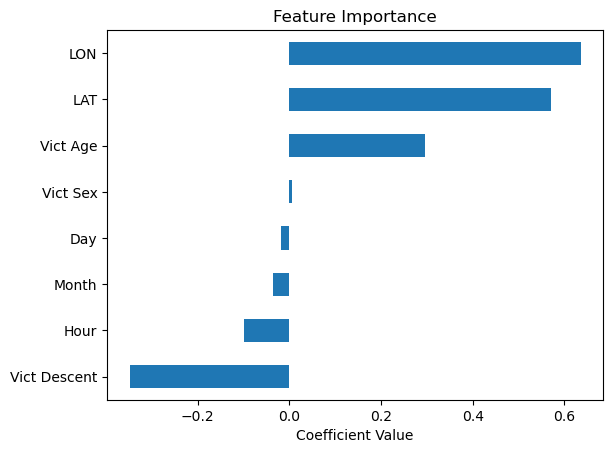

In [40]:
# Sort and plot
feature_importance.sort_values().plot(kind="barh", title="Feature Importance")
plt.xlabel("Coefficient Value")
plt.show()

# Save model

In [42]:
# Save logistic regression model
models_dir = 'path/to/models/directory/' # Change to your models directory
model_name = 'logreg_model.pkl' # Change to your model name
model_path = models_dir + model_name 
dump(model, model_path)

# Next Steps 🚀
- ## Try different models
### -- Decision Trees
### -- RandomForest
### -- XGBoost
- ## Tune hyperparameters using GridSearchCV